<a href="https://colab.research.google.com/github/Sayed-Hossein-Hosseini/Dancing_with_Polynomial_Predictions/blob/master/Dancing_with_Polynomial_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dancing with Polynomial Predictions**

## **Libraries**

In [18]:
import gdown
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

warnings.simplefilter(action='ignore', category=FutureWarning)

## **Dataset Description**

In [19]:
# Load the Excel file
file_path = 'Polynomial_Functions.xlsx'  # Change the path if needed
df = pd.read_excel(file_path, sheet_name='Sheet1')

# Display general information about the dataset
print("🔹 Dataset Information:")
print(df.info())

# Check for missing values in each column
print("\n🔹 Missing Values Per Column:")
print(df.isnull().sum())

# Show descriptive statistics
print("\n🔹 Descriptive Statistics:")
print(df.describe())

# Count unique values in each column
print("\n🔹 Number of Unique Values Per Column:")
print(df.nunique())


🔹 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   x           10000 non-null  float64
 1   y           10000 non-null  float64
 2   z           10000 non-null  float64
 3   F(x, y, z)  10000 non-null  float64
dtypes: float64(4)
memory usage: 312.6 KB
None

🔹 Missing Values Per Column:
x             0
y             0
z             0
F(x, y, z)    0
dtype: int64

🔹 Descriptive Statistics:
                  x             y             z    F(x, y, z)
count  10000.000000  10000.000000  10000.000000  10000.000000
mean      -0.116809      0.090598      0.001008     43.803057
std        5.752603      5.785891      5.735475    587.941231
min       -9.999767     -9.996845     -9.999038  -3191.680304
25%       -5.073423     -4.921084     -4.925042   -225.322605
50%       -0.149428      0.117936      0.041362     15.622764
75%      

## **Train/Test Split**

In [20]:
# Separate features and target
X = df.drop('F(x, y, z)', axis=1)
y = df['F(x, y, z)']

# Split into training and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the sizes
print(f"Training set size: {X_train.shape[0]} rows")
print(f"Test set size: {X_test.shape[0]} rows")


Training set size: 8000 rows
Test set size: 2000 rows


## **Preprocessing**

### **Remove Outliers**

In [21]:
def remove_outliers_auto_xy_with_output(x, y):
    """
    Automatically detect and remove outliers from the training data (x, y) using the IQR method.
    Removes rows from both x and y simultaneously when an outlier is detected in either x or y.

    Parameters:
        x (pd.DataFrame): Input feature DataFrame (training data)
        y (pd.Series): Input target Series (labels)

    Returns:
        pd.DataFrame, pd.Series: Cleaned feature DataFrame and target Series with outliers removed
    """
    initial_shape = x.shape
    print(f"🔹 Initial dataset size: {initial_shape[0]} rows, {initial_shape[1]} columns (x), {y.shape[0]} rows (y)\n")

    # For numeric columns in x
    numeric_cols_x = x.select_dtypes(include='number').columns
    x_clean = x.copy()
    y_clean = y.copy()

    # Remove outliers from x
    for col in numeric_cols_x:
        Q1 = x[col].quantile(0.25)
        Q3 = x[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        before = x_clean.shape[0]
        mask = (x_clean[col] >= lower_bound) & (x_clean[col] <= upper_bound)

        # Apply the same mask to both x and y
        x_clean = x_clean[mask]
        y_clean = y_clean[mask]

        after = x_clean.shape[0]
        removed = before - after

        if removed > 0:
            print(f"🟠 Removed {removed} outliers from column '{col}' in x")
        else:
            print(f"✅ No outliers detected in column '{col}' in x")

    # For the target variable y
    Q1_y = y_clean.quantile(0.25)
    Q3_y = y_clean.quantile(0.75)
    IQR_y = Q3_y - Q1_y
    lower_bound_y = Q1_y - 1.5 * IQR_y
    upper_bound_y = Q3_y + 1.5 * IQR_y

    before_y = y_clean.shape[0]
    y_mask = (y_clean >= lower_bound_y) & (y_clean <= upper_bound_y)

    # Apply the same mask to both x and y
    x_clean = x_clean[y_mask]
    y_clean = y_clean[y_mask]

    after_y = x_clean.shape[0]
    removed_y = before_y - after_y

    if removed_y > 0:
        print(f"🟠 Removed {removed_y} outliers from target variable y")
    else:
        print(f"✅ No outliers detected in target variable y")

    print(f"\n✅ Final dataset size: {x_clean.shape[0]} rows (removed {initial_shape[0] - x_clean.shape[0]} total rows)")
    return x_clean, y_clean

# Example usage:
X_train_clean, y_train_clean = remove_outliers_auto_xy_with_output(X_train, y_train)


🔹 Initial dataset size: 8000 rows, 3 columns (x), 8000 rows (y)

✅ No outliers detected in column 'x' in x
✅ No outliers detected in column 'y' in x
✅ No outliers detected in column 'z' in x
🟠 Removed 603 outliers from target variable y

✅ Final dataset size: 7397 rows (removed 603 total rows)


### **Normalize Data**

In [22]:
def normalize_data(X_train, X_test, y_train, y_test):
    """
    This function normalizes the training and test features (X) and outputs (y).

    Parameters:
        X_train (numpy array): Training features
        X_test (numpy array): Test features
        y_train (numpy array): Training outputs
        y_test (numpy array): Test outputs

    Returns:
        X_train_normalized (numpy array): Normalized training features
        X_test_normalized (numpy array): Normalized test features
        y_train_normalized (numpy array): Normalized training outputs
        y_test_normalized (numpy array): Normalized test outputs
        feature_scaler (dict): Feature normalization parameters (mean, std)
        output_scaler (dict): Output normalization parameters (mean, std)
    """
    # Step 1: Normalize features
    feature_mean = np.mean(X_train, axis=0)  # Mean of each feature in X_train
    feature_std = np.std(X_train, axis=0)    # Standard deviation of each feature in X_train
    X_train_normalized = (X_train - feature_mean) / feature_std
    X_test_normalized = (X_test - feature_mean) / feature_std

    # Step 2: Normalize outputs
    output_mean = np.mean(y_train)  # Mean of y_train
    output_std = np.std(y_train)    # Standard deviation of y_train
    y_train_normalized = (y_train - output_mean) / output_std
    y_test_normalized = (y_test - output_mean) / output_std

    # Store normalization parameters for later use (e.g., denormalization)
    feature_scaler = {"mean": feature_mean, "std": feature_std}
    output_scaler = {"mean": output_mean, "std": output_std}

    return X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized, feature_scaler, output_scaler

# Example usage
# Assume you have the following datasets
# X_train = np.array([
#     [-2.5092, -2.52718, 4.59997],
#     [9.01429, -3.34176, -6.30976],
#     [4.63988, -6.47692, -3.06721],
#     [1.97137, 2.14533, 3.26561],
#     [-6.87963, -0.46752, -0.35821]
# ])

# X_test = np.array([
#     [-6.88011, 7.31402, 4.77142],
#     [-8.83833, -9.35781, 9.22416]
# ])

# y_train = np.array([100, 200, 300, 400, 500])
# y_test = np.array([600, 700])

# Normalize the data
X_train_norm, X_test_norm, y_train_norm, y_test_norm, feature_scaler, output_scaler = normalize_data(X_train, X_test, y_train, y_test)

# print(y_train_clean.head())
# Display normalized data
print("Normalized Training Features (X_train):")
print(X_train_norm.head())
print("\nNormalized Testing Features (X_test):")
print(X_test_norm.head())
print("\nNormalized Training Outputs (y_train):")
print(y_train_norm.head())
print("\nNormalized Testing Outputs (y_test):")
print(y_test_norm.head())

# Denormalize outputs (example)
def denormalize(data, scaler):
    return data * scaler["std"] + scaler["mean"]

# Example: Denormalize y_train_normalized
y_train_denormalized = denormalize(y_train_norm, output_scaler)
print("\nDenormalized Training Outputs (y_train):")
print(y_train_denormalized.head())

Normalized Training Features (X_train):
             x         y         z
9254  0.965060 -1.228372  1.562923
1561 -0.890078 -0.860177 -1.131713
1670 -0.390623 -0.574062 -0.080309
6087 -0.997376  1.267594  1.060011
6669 -1.260285 -0.533248 -1.294791

Normalized Testing Features (X_test):
             x         y         z
6252 -0.540530 -1.400651  1.631321
4684  0.981357  0.986216 -1.062414
1731  0.454605 -1.014799  1.702356
4742 -1.589408  1.043178 -1.295144
4521  0.292076  1.511960 -0.506691

Normalized Training Outputs (y_train):
9254    0.194677
1561   -1.257305
1670   -0.120382
6087    0.680989
6669   -1.802561
Name: F(x, y, z), dtype: float64

Normalized Testing Outputs (y_test):
6252   -1.117454
4684    0.614837
1731    0.014081
4742   -0.687773
4521    0.518643
Name: F(x, y, z), dtype: float64

Denormalized Training Outputs (y_train):
9254     154.530442
1561    -701.158409
1670     -31.142075
6087     441.126098
6669   -1022.491378
Name: F(x, y, z), dtype: float64


## **Feature Engineering**

In [23]:
def feature_engineering(df):
    """
    This function takes a DataFrame with columns x, y, z as inputs
    and returns a feature matrix phi(x, y, z).

    The DataFrame must contain the columns 'x', 'y', and 'z'.
    """
    x = df['x']
    y = df['y']
    z = df['z']

    # Compute all the required terms
    phi = pd.DataFrame({
        # 'bias': 1,
        'x': x,
        'x2': x**2,
        'x3': x**3,
        'y': y,
        'y2': y**2,
        'y3': y**3,
        'z': z,
        'z2': z**2,
        'z3': z**3,
        'xy': x * y,
        'x2y': x**2 * y,
        'xy2': x * y**2,
        'xz': x * z,
        'x2z': x**2 * z,
        'xz2': x * z**2,
        'yz': y * z,
        'y2z': y**2 * z,
        'yz2': y * z**2,
        'xyz': x * y * z
    })

    return phi

# Example usage:
# Assuming X_train_norm and X_test_norm are DataFrames with columns 'x', 'y', 'z'
X_train_vector = feature_engineering(X_train_norm)
X_test_vector = feature_engineering(X_test_norm)

print("Feature Vector (Train):")
print(X_train_vector.head())
print("Feature Vector (Test):")
print(X_test_vector.head())

Feature Vector (Train):
             x        x2        x3         y        y2        y3         z  \
9254  0.965060  0.931340  0.898799 -1.228372  1.508898 -1.853487  1.562923   
1561 -0.890078  0.792239 -0.705154 -0.860177  0.739904 -0.636448 -1.131713   
1670 -0.390623  0.152586 -0.059604 -0.574062  0.329547 -0.189180 -0.080309   
6087 -0.997376  0.994759 -0.992148  1.267594  1.606796  2.036765  1.060011   
6669 -1.260285  1.588318 -2.001733 -0.533248  0.284353 -0.151631 -1.294791   

            z2        z3        xy       x2y       xy2        xz       x2z  \
9254  2.442728  3.817795 -1.185452 -1.144032  1.456176  1.508314  1.455613   
1561  1.280774 -1.449469  0.765624 -0.681465 -0.658572  1.007313 -0.896587   
1670  0.006450 -0.000518  0.224241 -0.087594 -0.128728  0.031371 -0.012254   
6087  1.123624  1.191054 -1.264268  1.260951 -1.602579 -1.057230  1.054455   
6669  1.676484 -2.170697  0.672044 -0.846967 -0.358366  1.631806 -2.056540   

           xz2        yz       y2z    

## **Model Implementation**

Epoch 1/100 - Train Loss: 1.0000 - Test Loss: 0.7510
Epoch 2/100 - Train Loss: 0.7731 - Test Loss: 0.5810
Epoch 3/100 - Train Loss: 0.6012 - Test Loss: 0.4525
Epoch 4/100 - Train Loss: 0.4709 - Test Loss: 0.3555
Epoch 5/100 - Train Loss: 0.3719 - Test Loss: 0.2821
Epoch 6/100 - Train Loss: 0.2966 - Test Loss: 0.2265
Epoch 7/100 - Train Loss: 0.2393 - Test Loss: 0.1844
Epoch 8/100 - Train Loss: 0.1955 - Test Loss: 0.1523
Epoch 9/100 - Train Loss: 0.1620 - Test Loss: 0.1279
Epoch 10/100 - Train Loss: 0.1363 - Test Loss: 0.1093
Epoch 11/100 - Train Loss: 0.1165 - Test Loss: 0.0949
Epoch 12/100 - Train Loss: 0.1011 - Test Loss: 0.0838
Epoch 13/100 - Train Loss: 0.0891 - Test Loss: 0.0752
Epoch 14/100 - Train Loss: 0.0796 - Test Loss: 0.0684
Epoch 15/100 - Train Loss: 0.0721 - Test Loss: 0.0630
Epoch 16/100 - Train Loss: 0.0661 - Test Loss: 0.0586
Epoch 17/100 - Train Loss: 0.0612 - Test Loss: 0.0550
Epoch 18/100 - Train Loss: 0.0572 - Test Loss: 0.0521
Epoch 19/100 - Train Loss: 0.0539 - T

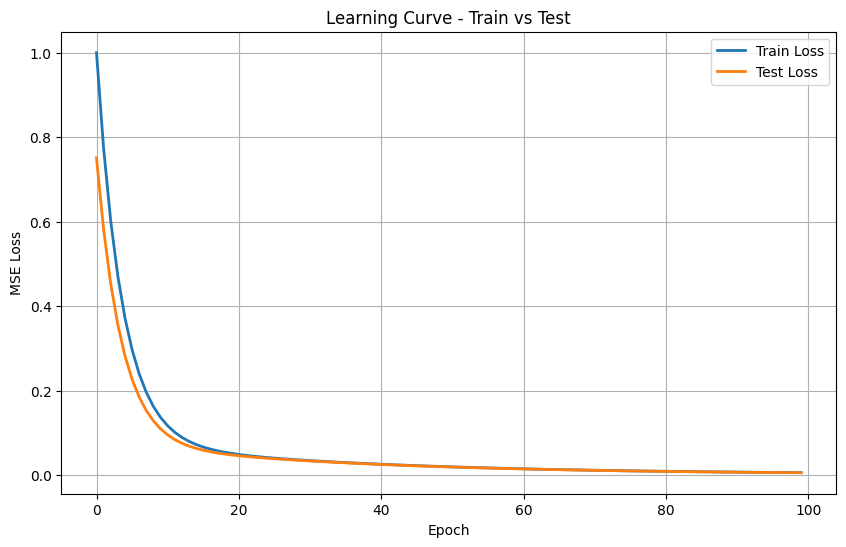

In [25]:
# Mean Squared Error (manual implementation)
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Linear regression training function
def linear_regression(X_train, y_train, X_test, y_test, learning_rate=0.01, epochs=100):
    n_samples, n_features = X_train.shape
    weights = np.zeros(n_features)
    bias = 0
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Forward pass - prediction on training data
        y_pred_train = np.dot(X_train, weights) + bias

        # Compute training loss
        train_loss = mse_loss(y_train, y_pred_train)
        train_losses.append(train_loss)

        # Backward pass - gradients
        error = y_pred_train - y_train
        dw = (2 / n_samples) * np.dot(X_train.T, error)
        db = (2 / n_samples) * np.sum(error)

        # Update weights and bias
        weights -= learning_rate * dw
        bias -= learning_rate * db

        # Evaluate test loss
        y_pred_test = np.dot(X_test, weights) + bias
        test_loss = mse_loss(y_test, y_pred_test)
        test_losses.append(test_loss)

        # Print progress
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f}")

    return weights, bias, train_losses, test_losses


weights, bias, train_losses, test_losses = linear_regression(X_train_vector, y_train_norm, X_test_vector, y_test_norm, learning_rate=0.01, epochs=100)

print("\n🔹 Final Weights:", weights)
print("🔹 Final Bias:", bias)
print(f"\n✅ Final Train MSE: {train_losses[-1]:.4f}")
print(f"✅ Final Test MSE: {test_losses[-1]:.4f}")

# === Plot learning curves ===
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss", linewidth=2)
plt.plot(test_losses, label="Test Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Learning Curve - Train vs Test")
plt.legend()
plt.grid(True)
plt.show()

